# Impresión de Resultados GANs

## Importe de bibliotecas

In [1]:
from __future__ import print_function, division

#Se importan las bibliotecas. En caso de querer hacer este proceso directamente
#en un ordenador se deben instalar las bilbiotecas que se indican a continuacion:

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import h5py
import sklearn
import glob
import keras
import time
import imp
import os
import tensorflow as tf 
import pandas as pd
import sys

#Estas bibliotecas no son necesarias en su totalidad, solo se requieren ciertas
#funciones
from random import shuffle
from skimage import io
from collections import Counter
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

from keras.datasets import mnist

#Importe de funciones especificas de bibliotecas ya importadas
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import BatchNormalization, ZeroPadding2D, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.convolutional import UpSampling2D
from keras.optimizers import SGD, Adam

from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize
from keras.datasets.mnist import load_data

from scipy.stats import wasserstein_distance

import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#lineas requeridas solo en jupyter notbook
from IPython.display import clear_output
%matplotlib notebook
%matplotlib inline

Using TensorFlow backend.


## Lectura de imágenes originales

In [3]:
#Se inicia definiendo el diccionario map_characters, este posee originalmente 18
#personajes, si se agrega otro más se debe agregar al diccionario y colocarsele 
#el número consecutivo que corresponda

map_characters = {0: 'trainingCoffee'}
                  
#Se define el numero de clases con la extensión del diccionario
num_classes = len(map_characters)

#Número máximo de imagenes que se usaran por personaje para entrenar
pictures_per_class = 100000

def load_pictures(test_size, pic_size,BGR):
    """
    Load pictures from folders for characters from the map_characters dict and create a numpy dataset and 
    a numpy labels set. Pictures are re-sized into picture_size square.
    :param BGR: boolean to use true color for the picture (RGB instead of BGR for plt)
    :return: dataset, labels set
    """
    pics = []    #Se crea la lista de imagenes de salida
    labels = []  #Se crea la lista de etiquetas de salida

    #k es el numero de la variable en el diccionario
    #char es el nombre de la variable en el diccionario
    # El if lo que hace es que recorra cada una de las variables del diccionario
    for k, char in map_characters.items(): 

        #Esta linea deivuelve la lista de rutas de las imagenes de cada personaje del diccionario
        # Ej: para char = 'abraham_grampa_simpson' regresa todas las rutas de imagen de la carpeta
        # abraham_grampa_simpson que a su vez esta en la carpeta characters.
        #Es solo una forma elegante y rapida de optener todas las rutas
        pictures = [k for k in glob.glob('./source/trainingSet/%s/*' % char)]

        #Se establece la cantidad de imagenes que se van a usar en cada clase
        #Como maximo se usan 1176 imagenes, estas son tanto para train como para test
        #Si el personaje en particular tiene menos de 1176 imagenes se usara la extension del personaje en cuestion
        nb_pic = round(pictures_per_class/(1-test_size)) if round(pictures_per_class/(1-test_size))<len(pictures) else len(pictures)

        #Se usa la funcion random para ordenar de manera aleatoria las imagenes de cada personaje
        #Cabe detacar que pic es una ruta de acceso aleatoria de la lista de rutas de acceso en pictures
        for pic in np.random.choice(pictures, nb_pic):

            #Se lee la imagen de la ruta "pic"
            a = cv2.imread(pic)
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
            # a = cv2.imread(pic, cv2.IMREAD_GRAYSCALE)

            #Se hace un resize de las imagenes a pic_size x pic_size. Por defecoto
            #este es 64x64. Esto concuerda con los pixeles de entrada de la red neuronal
            a = cv2.resize(a, (pic_size,pic_size))

            #Se agrega la imagen leida, convertida y escalada a la lista pics
            pics.append(a)
            #Se agrega la etiqueta numérica de la lista de etiquetas, esta etiqueta numerica 
            #concuerda con el número en el diccionario map_characters
            labels.append(k)

    #Se devuelve las listas pero antes se transforman a un formato de array con numpy
    return np.array(pics), np.array(labels) 

def get_dataset(save=False, load=False, BGR=False, test_size=0.1, pic_size=64):
    #Primero se llama a la funcion load_pictures, por defecto se deja estas en 
    #blanco y negro
    #En esta funcion tambien se extraen los labels del archivo txt anotations
    X, y = load_pictures(test_size, pic_size, BGR)

    #Luego se pasa los labels a un formato numerico y en listas separadas,
    #por ejemplo si el label es 2 to_categorical lo pasa a una lista [0 0 1 ... 0]
    #El tamaño de la lista depende de cuantas clases se tenga, en este ejemplo son 18
    y = keras.utils.to_categorical(y, num_classes)

    #Se normaliza las imagenes para que los valores de cada banda esten en punto flotante
    #y además se encuentren entre 0 y 1. Esto ayuda a la velocidad de entrenamiento           
    X = X.astype('float32') / 255.
    
    #Se imprime las formas de cada tensor. Si se mantienen todas las variables 
    #por defecto estas deben ser (x,64,64,3) y (x,w), donde x es el numero de imagenes
    #y w es la cantidad de clases en el diccionario
    print("Train", X.shape, y.shape)

    return X, y

#Uso de funciones de lectura para dividir el set de imagnes en test y train
X, y = get_dataset(save=True)

Train (19017, 64, 64, 3) (19017, 1)


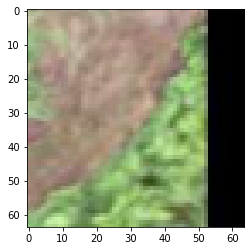

(-0.5, 63.5, 63.5, -0.5)

In [4]:
fig, axs = plt.subplots(1, 1)

axs.imshow(X[5])
plt.show()
axs.axis('off')

## Resultados de GANs

Con los pesos y los datos obtenidos durante el entrenamiento y se realizan las siguientes acciones:

* En Primero se va a imprimir una imagen que corresponde a un collage de con 10x10 resultados de la CNN generadora.
* En Segundo lugar se va a imprimir una imagen que corresponde a un collage de 10x10 imagenes originales seleccionadas aleatoriamente.
* En tercer lugar se lee el csv de resultados que se genera durante el entrenamiento y se imprime una gráfica para facilitar la visualización de los datos.
* Finalmente se calcula el FID para dar una idea de que tan similares son las imágenes generadas con las originales.

### Collage de imágenes generadas

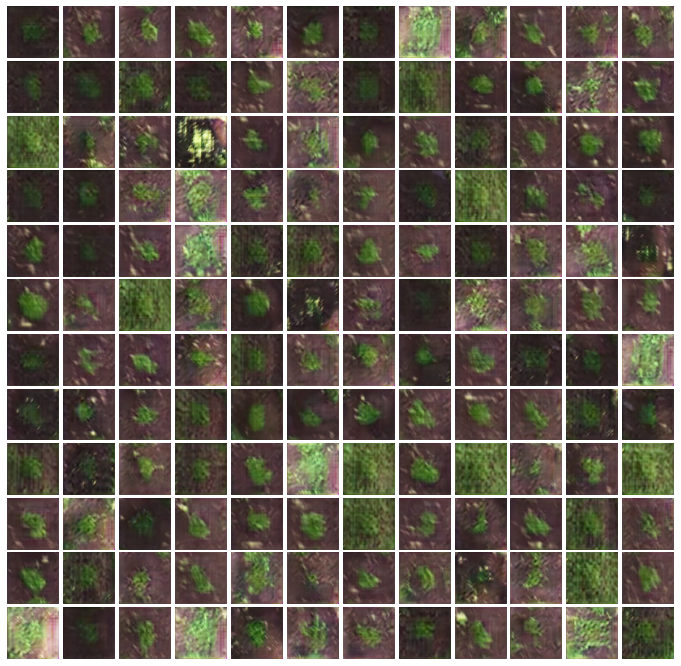

In [3]:
img_rows = 64
img_cols = 64
channels = 3
latent_dim = 100
img_shape = (img_rows, img_cols, channels)
img_shape

Filtros_Iniciales = 64
upsample_layers = 5
Kernels = 3

def build_generator():
    noise_shape = (latent_dim,)
    
    model = Sequential()

    model.add(Dense(Filtros_Iniciales * (img_rows // (2 ** upsample_layers))  *  (img_cols // (2 ** upsample_layers)), activation="relu", input_shape=noise_shape))
    model.add(Reshape(((img_rows // (2 ** upsample_layers)),
                       (img_cols // (2 ** upsample_layers)),
                       Filtros_Iniciales)))
    
    model.add(BatchNormalization(momentum=0.8))
        
    model.add(UpSampling2D())
    model.add(Conv2D(1024, kernel_size=Kernels, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(UpSampling2D())
    model.add(Conv2D(512, kernel_size=Kernels, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=Kernels, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=Kernels, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=Kernels, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Conv2D(channels, kernel_size=Kernels, padding="same"))
    model.add(Activation("tanh"))
    model.add(Reshape(img_shape))

    noise = Input(shape=(latent_dim,))
    fake_img = model(noise)

    return Model(noise, fake_img)


#=========================================================================
#Lectura de los pesos de la red generadora
optimizer = Adam(0.0002, 0.5)

new_model = build_generator()
new_model.compile(loss='binary_crossentropy', optimizer=optimizer)

#new_model.load_weights('Resultados_64_64/generator_64_64_weigths.h5')
new_model.load_weights('Resultados_64_64/EFinal/generator_64_64_weigths.h5')

#=========================================================================
#Impresión del collage

r, c = 12, 12
noise = np.random.normal(0, 1, (r * c, latent_dim))
gen_imgs = new_model.predict(noise)

# Rescale images 0 - 1
gen_imgs = abs(gen_imgs)

cnt = 0

fig = plt.figure(figsize=(r, c))
gs = gridspec.GridSpec(r, c)
gs.update(wspace=0.025, hspace=0.05)

for i in range(r):
    for j in range(c):
        ax = plt.subplot(gs[i,j])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('auto')
        plt.imshow((gen_imgs[cnt] * 255).astype(int))
        cnt += 1

plt.savefig('out2.png', bbox_inches='tight')

### Collage de imágenes originales

In [ ]:
r, c = 10, 10

fig = plt.figure(figsize=(r, c))
gs = gridspec.GridSpec(r, c)
gs.update(wspace=0.025, hspace=0.05)

for i in range(r*c):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(X[random.randint(0,19000)])

plt.savefig('in.png', bbox_inches='tight')

### Impresión de datos recolectados durante entrenamiento

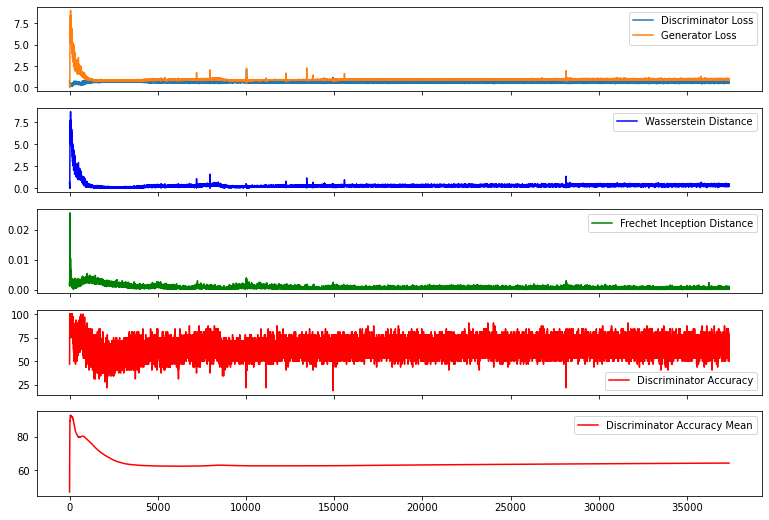

In [20]:
Data = pd.read_csv('results.csv')
itr_list = list(Data.itr)
acc_list = list(Data.acc)
d_loss_list = list(Data.d_loss)
g_loss_list = list(Data.g_loss)
wasserstein_distance_list = list(Data.w_distance)
fid_list = list(Data.fid)
acc_list_prom = []

for i in range(1, len(itr_list)):
    acc_list_prom.append(np.mean(acc_list[0:i]))

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex='col', figsize=(13,9))

ax1.plot(itr_list, d_loss_list, label = "Discriminator Loss")
ax1.plot(itr_list, g_loss_list, label = "Generator Loss")
ax1.legend()

#
ax2.plot(itr_list, wasserstein_distance_list, '-b', label = "Wasserstein Distance")
ax2.legend()

#
ax3.plot(itr_list, fid_list, '-g', label = "Frechet Inception Distance")
ax3.legend()

# Create two subplots and unpack the output array immediately
ax4.plot(itr_list, acc_list, '-r', label = "Discriminator Accuracy")
ax4.legend()

# Create two subplots and unpack the output array immediately
ax5.plot(itr_list[1:], acc_list_prom, '-r', label = "Discriminator Accuracy Mean")
ax5.legend()

### Cálculo de la metrica de FID

In [8]:
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(128, 128, 3))
model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=True)

In [9]:
#------------------------------------------
# Calculo de Frechet Inception Distance
#------------------------------------------

# Se seleccionan las imagenes
imgs = X

# El generador da un numero igual de imagenes sinteticas
noise = np.random.normal(0, 1, (len(X), latent_dim))
gen_imgs = new_model.predict(noise)

# resize images
images1 = scale_images(imgs, (128,128,3))
images2 = scale_images(gen_imgs, (128,128,3))

# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)

# calculate fid
fid = calculate_fid(model, images1, images2)
fid

0.00033231892808809527